<a href="https://colab.research.google.com/github/wangjb/MLprojs/blob/master/cl_30days_meteo_manned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import urllib
from sklearn.preprocessing import LabelEncoder, StandardScaler

# from pprint import pprint
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
def retrieve_data(datacode,auth):
  # query string to CWB open data mservice
  url='https://opendata.cwb.gov.tw/'
  sub_path='fileapi/v1/opendataapi/'
  # instant 10 min precip
  datalimit=''
  dataoffset=''
  dataformat='JSON'
  stationID=''
  datastatus=''

  # create query string
  url_path=url+sub_path+datacode
  query_fields=['Authorization','limit','offset','format','stationID','status']
  query_data=(auth,datalimit,dataoffset,dataformat,stationID,datastatus)
  query_string=dict(zip(query_fields,query_data))

  # request data
  import requests
  r = requests.get(url_path,params=query_string,stream=True)
  jsondata = r.json()

  return jsondata

In [ ]:
datacode = 'C-B0024-001'
auth = 'CWB-31ADCF8F-BA9A-4418-A7C0-9D3C0761F8F6'
jsondata = retrieve_data(datacode, auth)

In [ ]:
data = jsondata['cwbdata']['resources']['resource']['data']['surfaceObs']['location']

In [ ]:
data[0].keys()

dict_keys(['station', 'stationObsTimes', 'stationObsStatistics'])

### Variable "station"

In [ ]:
# process station info
station = pd.DataFrame(list(map(
    lambda x : x['station'],
      data)))
station.set_index('stationID', inplace=True)
station

,stationName,stationNameEN,stationAttribute
stationID,,,
466880,板橋,BANQIAO,局屬有人氣象站
466900,淡水,TAMSUI,局屬有人氣象站
466910,鞍部,ANBU,局屬有人氣象站
466920,臺北,TAIPEI,局屬有人氣象站
466930,竹子湖,ZHUZIHU,局屬有人氣象站
466940,基隆,KEELUNG,局屬有人氣象站
466950,彭佳嶼,PENGJIAYU,局屬有人氣象站
466990,花蓮,HUALIEN,局屬有人氣象站
467050,新屋,XINWU,局屬有人氣象站


### Variable "stationObsTimes"

In [ ]:
# process stationObsTimes	
stationObsTime = pd.DataFrame.from_dict({ (data[i]['station']['stationID'],w['dataTime'].split('T')[0], w['dataTime'].split('T')[1]) : w['weatherElements']
            for i,v in enumerate(data)
            for j,w in enumerate(v['stationObsTimes']['stationObsTime'])
          }, orient='Index')
stationObsTime.index.set_names(['stationID', 'date', 'time'], inplace=True)
stationObsTime.sort_index(inplace=True)
stationObsTime
# stationObsTime.loc['466880', :, '01:00:00+08:00']

stationPressure  ... sunshineDuration
stationID date       time                            ...                 
466880    2020-12-28 01:00:00+08:00          1016.2  ...             None
                     02:00:00+08:00          1016.0  ...             None
                     03:00:00+08:00          1015.4  ...             None
                     04:00:00+08:00          1015.3  ...             None
                     05:00:00+08:00          1015.4  ...             None
...                                             ...  ...              ...
467990    2021-01-27 20:00:00+08:00          1010.1  ...             None
                     21:00:00+08:00          1010.1  ...             None
                     22:00:00+08:00          1010.2  ...             None
                     23:00:00+08:00          1010.2  ...             None
                     24:00:00+08:00          1010.4  ...             None

[22320 rows x 7 columns]

### Varaible "stationObsStatistics"

In [ ]:
# process stationObsStatistics	
from itertools import islice
stationObsStatistics = pd.DataFrame.from_dict({ (data[i]['station']['stationID'],w['dataDate']) : dict(islice(w.items(), 1, None))
              for i,v in enumerate(data)
              for j,w in enumerate(v['stationObsStatistics']['temperature']['daily'])
            },orient='Index')
stationObsStatistics.index.set_names(['stationID', 'date'], inplace=True)
stationObsStatistics.sort_index(inplace=True)
stationObsStatistics

maximum minimum  mean
stationID date                            
466880    2020-12-28    22.0    17.6  20.1
          2020-12-29    25.8    18.5  20.9
          2020-12-30    19.8    10.1  12.0
          2020-12-31    10.9     7.5   9.5
          2021-01-01    16.1    10.7  13.3
...                      ...     ...   ...
467990    2021-01-23    16.3    11.4  13.0
          2021-01-24    13.9     9.9  11.3
          2021-01-25    15.8     9.5  12.0
          2021-01-26    17.2    11.2  12.8
          2021-01-27    14.2    10.5  11.5

[930 rows x 3 columns]

### probability regression of temperature data

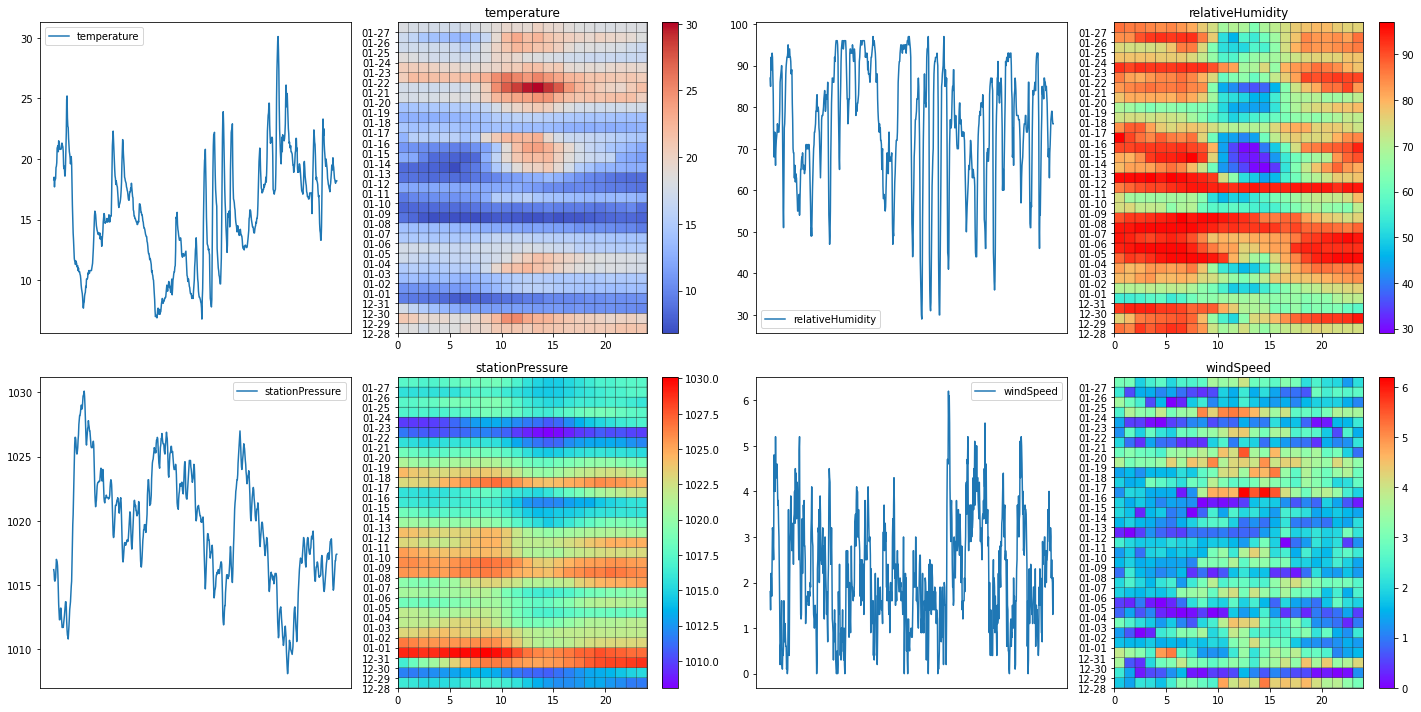

In [ ]:
stationid = '466880'
variables = ['temperature',	'relativeHumidity', 'stationPressure', 'windSpeed']
cmap = ['coolwarm', 'rainbow', 'rainbow', 'rainbow']
# lims = [[10,35], [None,None], [None, None]]
df = stationObsTime.loc[stationid][variables].astype(float)
m,n = len(df.index.levels[0]), len(df.index.levels[1])
arr = df.values.reshape(m,n,-1)
dates = df.index.levels[0].str[5:].values

fig = plt.figure(figsize=(20,10))
for i, var in enumerate(variables):
  ax = plt.subplot(2,4,i*2+1)
  ax.axes.get_xaxis().set_visible(False)
  df.plot(y=var, rot=90, ax=ax)
  
  # ax.xaxis.label.set_visible(False)

  ax = plt.subplot(2,4,i*2+2)
  im = ax.pcolor(arr[:,:,i], cmap=cmap[i], edgecolors='k')
  ax.set_yticks(np.arange(31))
  ax.set_yticklabels(dates)
  ax.set_title(var)
  fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

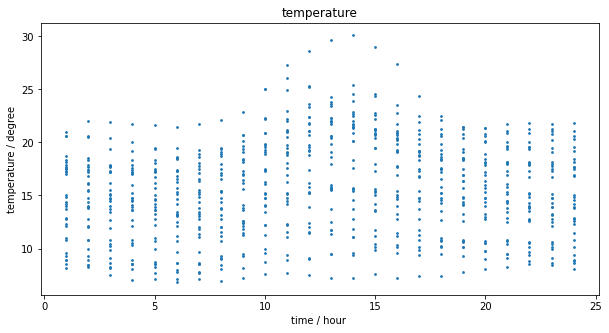

In [ ]:
# 準備訓練資料
# 取出溫度資料、轉成float、依時間index排序、將時間index改為column
variable = 'temperature'
df = stationObsTime.loc['466880'][variable].astype(float).sort_index(level=1).reset_index(level=1)

# 將時間資料做label encoding轉為對應由零開始的整數
encoder = LabelEncoder() 
df['time'] = encoder.fit_transform(df['time']) + 1
train_data = df.to_numpy()

x = train_data[:,0]  # 將時間資料encode後成果
y = train_data[:,1]  # 溫度資料
plt.figure(figsize=(10,5))
plt.scatter(x, y, s=3)
plt.ylabel('temperature / degree')
plt.xlabel('time / hour ')
plt.title(variable)
plt.show()

In [ ]:
# 建立模型
encoded_shape = 1
model = tf.keras.Sequential([
  tf.keras.layers.Dense(256, activation='relu'),                           
  tf.keras.layers.Dense(256, activation='relu'),                           
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(tfp.layers.IndependentNormal.params_size(encoded_shape)),
  tfp.layers.IndependentNormal(encoded_shape)
])

# 訓練model時所用的 loss function - negative log-likelihood
nll = lambda y, rv_y: -rv_y.log_prob(y)

# 訓練模型
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss=nll)
model.fit(x, y, epochs=2000, verbose=False)

In [ ]:
model.evaluate(x,y)

24/24 [==============================] - 0s 1ms/step - loss: 2.8625


2.8624651432037354

In [ ]:
# 使用訓練好的模型得出在每個時間之溫度預測機率分布
x_range = [1, 24]
n_tst = 24
x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
x_tst = x_tst[..., np.newaxis]
yhat = model(x_tst)
yhat

<tfp.distributions.Independent 'sequential_independent_normal_IndependentNormal_Independentsequential_independent_normal_IndependentNormal_Normal' batch_shape=[24] event_shape=[1] dtype=float32>

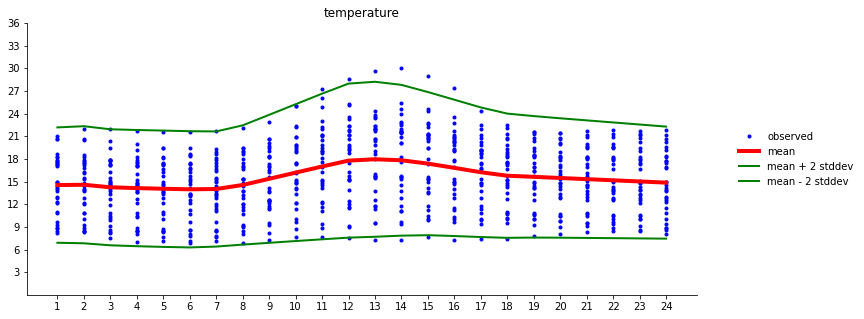

In [ ]:
# 將訓練資料與模型預測所得溫度平均值以及兩標準差之值隨時間作圖

plt.figure(figsize=[12, 5])
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(0,35);
plt.yticks(np.linspace(0, 36, 13)[1:]);
plt.xticks(np.linspace(*x_range, num=24));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title(variable)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.show()

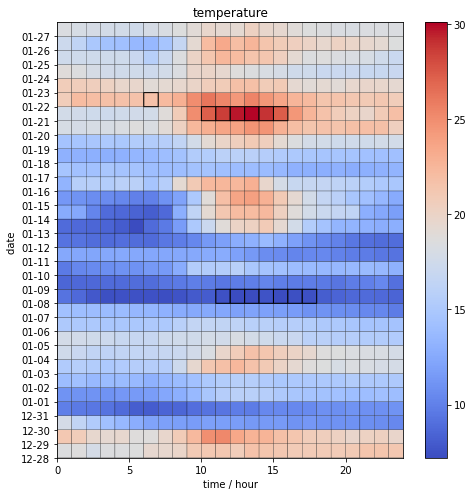

In [ ]:
# 標記出落在兩個標準差以外之高溫值與低溫值
mean = m.numpy().T
std = s.numpy().T
check = np.logical_or(arr[...,0] >= (mean + 2*std), arr[...,0] <= (mean - 2*std))

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(1,1,1)
ax.pcolor(arr[...,0], cmap='coolwarm', edgecolor='k')
im = ax.pcolor(np.where(check, arr[...,0], np.nan), cmap='coolwarm', edgecolors='k', linewidth=1)
ax.set_yticks(np.arange(31))
ax.set_yticklabels(dates)
fig.colorbar(im, ax=ax)
ax.set_title(variable)
ax.set_ylabel('date ')
ax.set_xlabel('time / hour')
plt.tight_layout()
plt.show()